# Funciones de apoyo

## Imprimir Histogramas

In [384]:
options(repr.plot.weight=16,repr.plot.height=8)

In [385]:
imprimir_histograma<-function(serie=x,leyenda="topleft"){
    hist(serie,breaks=100,freq=FALSE,main="Histograma")                                      #imprime el histograma 
    datos_normales<-rnorm(1000000,mean = mean(serie),sd=sqrt(var(serie)))                    #propone una serie normal
    curve(dnorm(x,mean(datos_normales),sd(datos_normales)),col="blue",lty=2,lwd=3,add=TRUE)  #dibuja una campana normal
    d<-density(serie)                                                                        #Densidad no parametrica
    lines(d,col="red",lwd=2)                                                                 #Dibuja una densidad no parametrica
    
    legend(leyenda,c("Distribución no parametrica","Distribución normal"),col=c("red","blue"),lwd=c(3,3),bty="n") #Leyenda
}

## Aplicar transformaciones

In [386]:
aplicar_transformacion<-function(serie=x,tipo=1,retardo=1){ #la serie por defecto será x,
                                                  ##El tipo 1 (por defecto) hará referencia a la diferenciacion de los datos (Cambio Absoluto)
                                                  ###El tipo 2 hará referencia a la transformacion Pt/Pt-1 (Rentabilidad bruta simple)
                                                  ####El tipo 3 hara referencia a la tranformacion Pt/Pt-1 -1 (Rentabilidad neta simple)
                                                  #####El tipo 4 hara referencia la transformacion log(Pt/Pt-1) Rentabilidad logaritmica
                                                  ######El tipo 5 hara referencia a la transformacion raiz cuadrada
                                                  #######El tipo 6 hara referencia  a la transformacion raiz cubica
                                                  ########El tipo 7 hara referenica a la transformacion ln(Pt)
    if(tipo==1){
        transformada<-diff(serie,retardo)
    }
    if(tipo==2){
        transformada<-c(NaN,serie[2:length(serie)]/serie[1:length(serie)-1])
    }
    
    if(tipo==3){
        transformada<-c(NaN,(serie[2:length(serie)]/serie[1:length(serie)-1])-1)
    }
    
    if(tipo==4){
        transformada<-c(NaN,log(serie[2:length(serie)]/serie[1:length(serie)-1]))
    }
    
    if(tipo==5){
        transformada<-sqrt(serie)
    }
    
    if(tipo==6){
        transformada<-(serie)^(1/3)
    }
    
    if(tipo==7){
        transformada<-log(serie)
    }
    return(transformada)
}



## Estadisticos Básicos

In [387]:
estadisticos_basicos<-function(serie=x,num_dec=6){ #informa los estadisticos descriptivos básicos de una serie, 
                                                   #se pueden configurar los decimales!!
    #library(moments)
    media<-round(mean(serie),num_dec)
    varianza<-round(var(serie),num_dec)
    asimetria<-round(skewness(serie),num_dec)
    curtosis<-round(kurtosis(serie),num_dec)
    total_datos<-length(serie)
    minimo<-round(min(serie),num_dec)
    maximo<-round(max(serie),num_dec)

    estadisticos<-c(media=media,varianza=varianza,asimetria=asimetria,curtosis=curtosis,minimo=minimo,maximo=maximo,total_datos=total_datos)
    return(estadisticos)
}

# Graficas QQ-Plot

In [388]:
grafico_qqplot<-function(serie=x){
    qqnorm(serie, main="Gráfico Q-Q")
    qqline(serie)
}

# Modelo univariado para el pronostico de la electricidad en Colombia

A continuacion se presenta la serie de tiempo correspondiente a los precios promedios aritmeticos en valores corrientes y valores constantes en una resolucion diaria.

En adelante, se continuará trabajando con la serie de tiempo constante pues cuenta con la corrección de la inflacion a precios del 2008

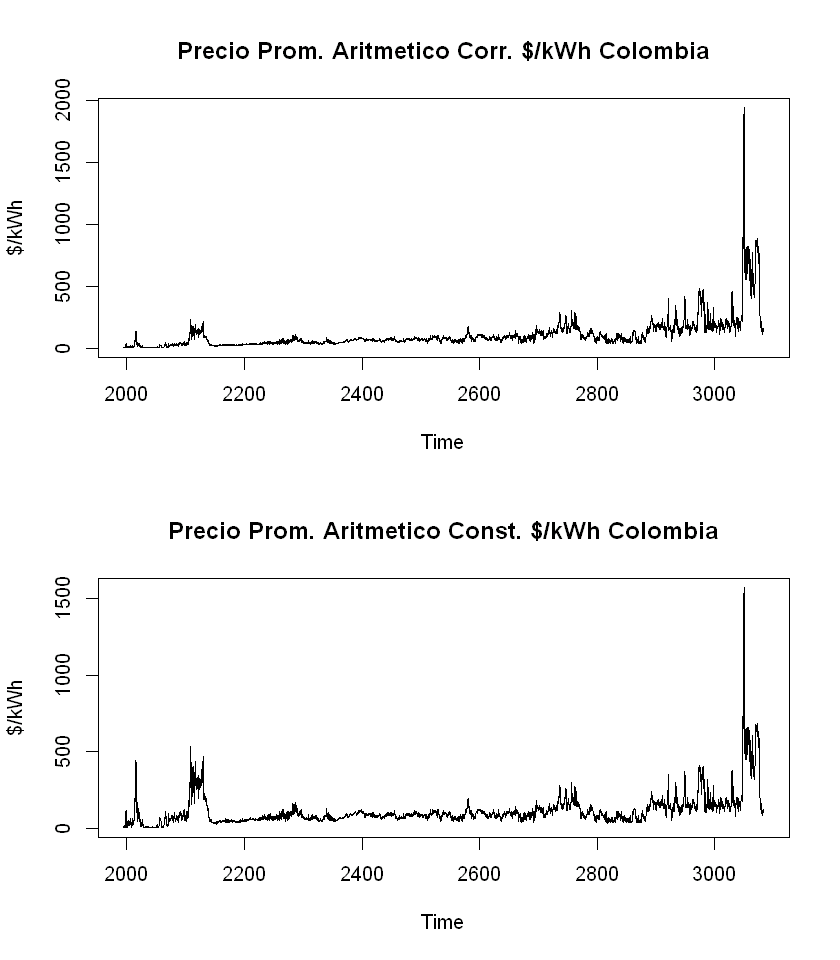

In [390]:
datos<-read.table("Precios_1995.csv",sep=",",header = TRUE)
current_price<-datos$Promedio_Aritmetico_...kWh._Corriente
current_price<-ts(current_price,frequency = 7,start=c(1995,1))
par(mfrow=c(2,1))
plot.ts(current_price, main="Precio Prom. Aritmetico Corr. $/kWh Colombia",ylab="$/kWh")
constant_price<-datos$X..KWh_Const_Dic_2008
constant_price<-ts(constant_price,frequency = 7,start=c(1995,1))
plot.ts(constant_price, main="Precio Prom. Aritmetico Const. $/kWh Colombia",ylab="$/kWh")


A continuacion veamos el comportamiento de la serie en terminos de autocorrelacion, es decir, verificar si con esta es optima para pronosticar:

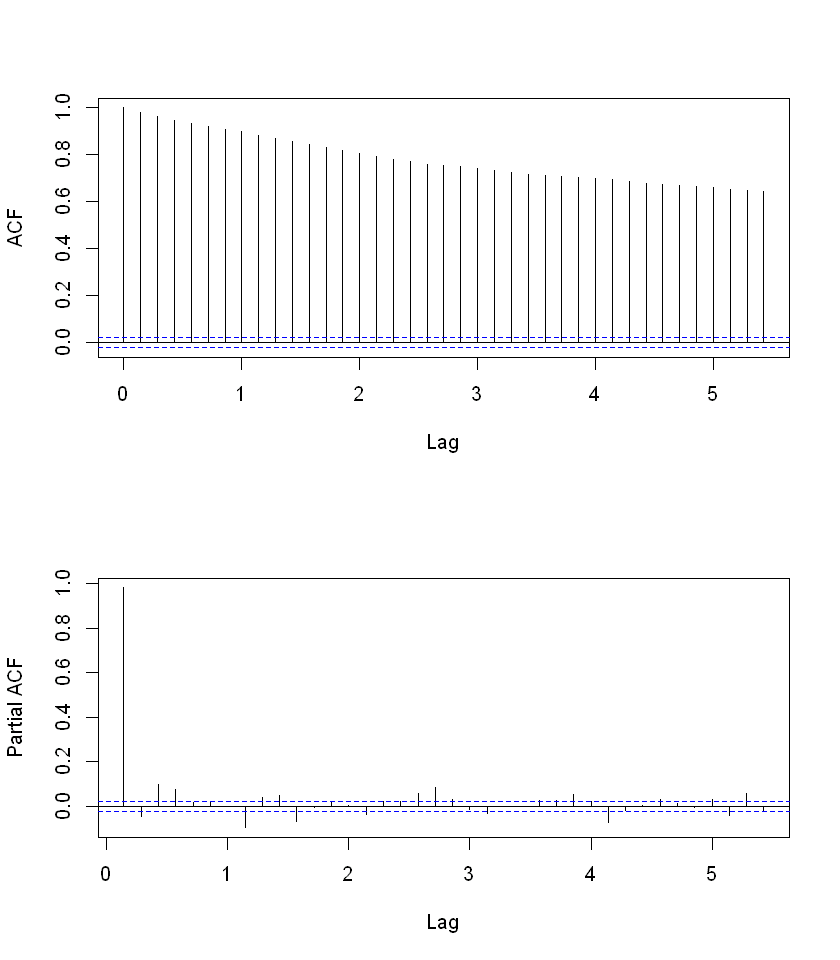

In [391]:
par(mfrow=c(2,1))
acf(constant_price, main="")
pacf(constant_price,main="")

Como la serie está integrada, se procede a transformar los datos. En este caso se aplicará una rentabilidad logaritmica, es decir $W_t= Ln(\frac{P_t}{P_{t-1}})$

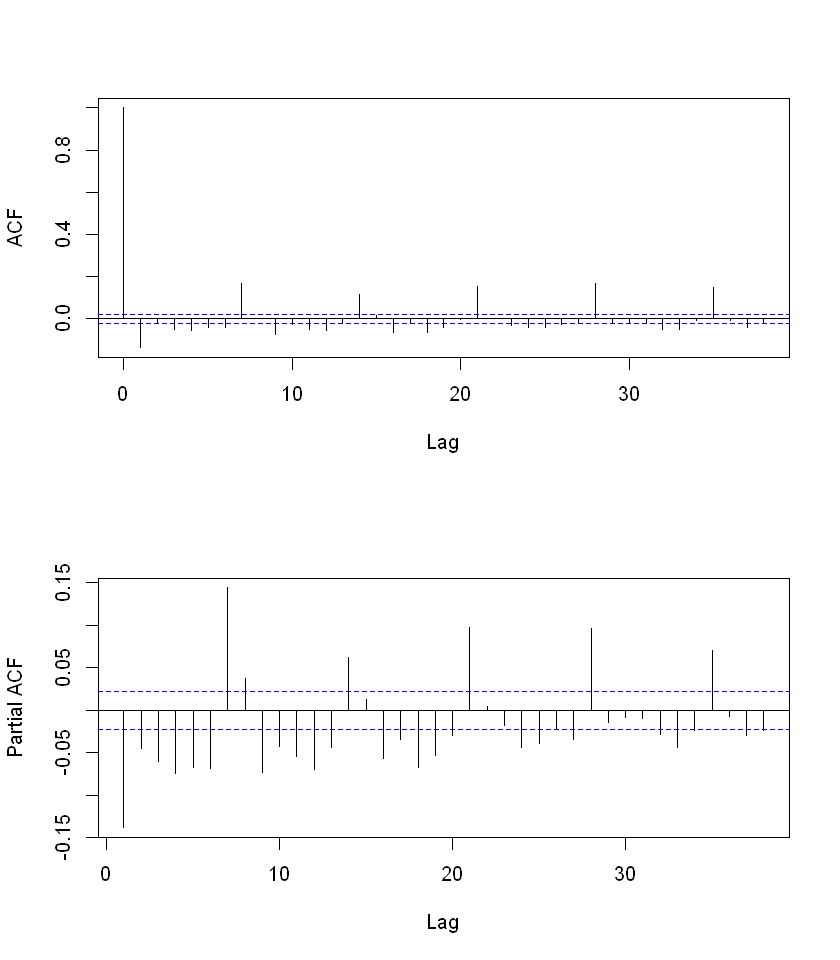

In [395]:
rend.log<-aplicar_transformacion(serie = constant_price,tipo = 4) #aplica la transformacion
rend.log<-rend.log[2:length(rend.log)] #Elimina los NA´s
par(mfrow=c(2,1))
acf(rend.log,main="") #imprime el ACF
pacf(rend.log,main="") #imprime el PACF

Como se puede observar, la serie tiene una estacionalidad en los datos $t+7$ lo cual indica que debe ser diferenciada con un rezago de 7 periodos

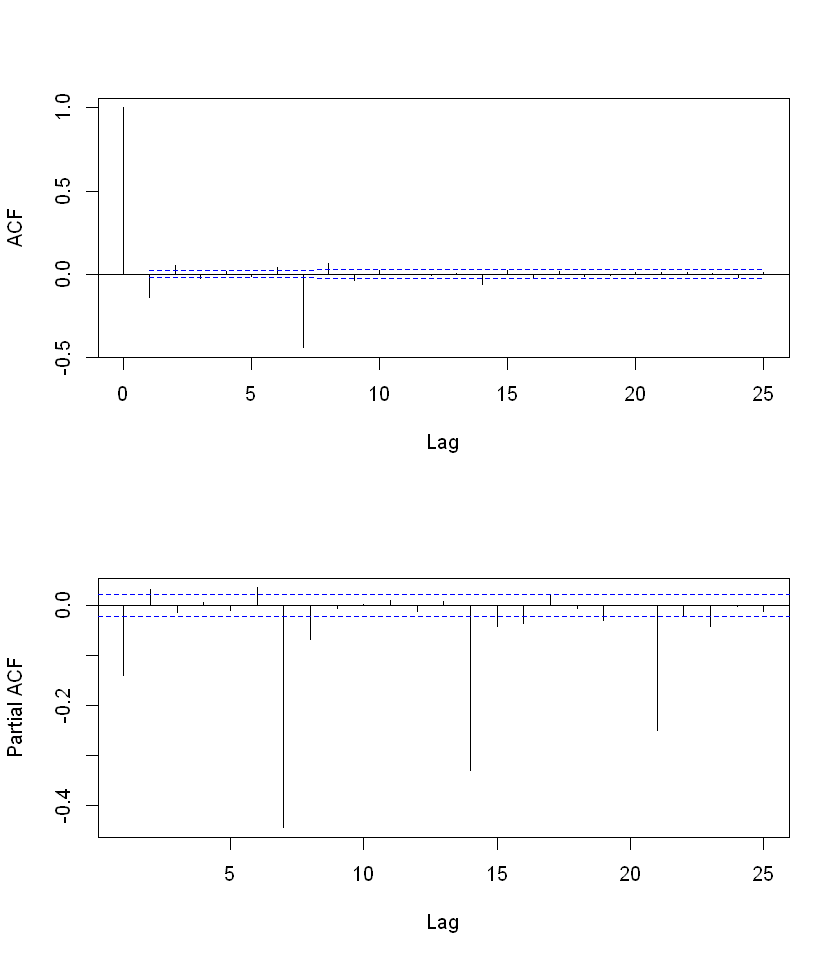

In [396]:
m.log.est7<-diff(rend.log,lag = 7)
par(mfrow=c(2,1))
acf(m.log.est7,main="",lag.max = 25,ci.type="ma")
pacf(m.log.est7,main="",lag.max = 25)

Hemos removido la componente estacional en el ACF y vemos algunos datos significativos en el PACF, por lo tanto procedemos a ajustar un AR(p) con la funcion ar.ols

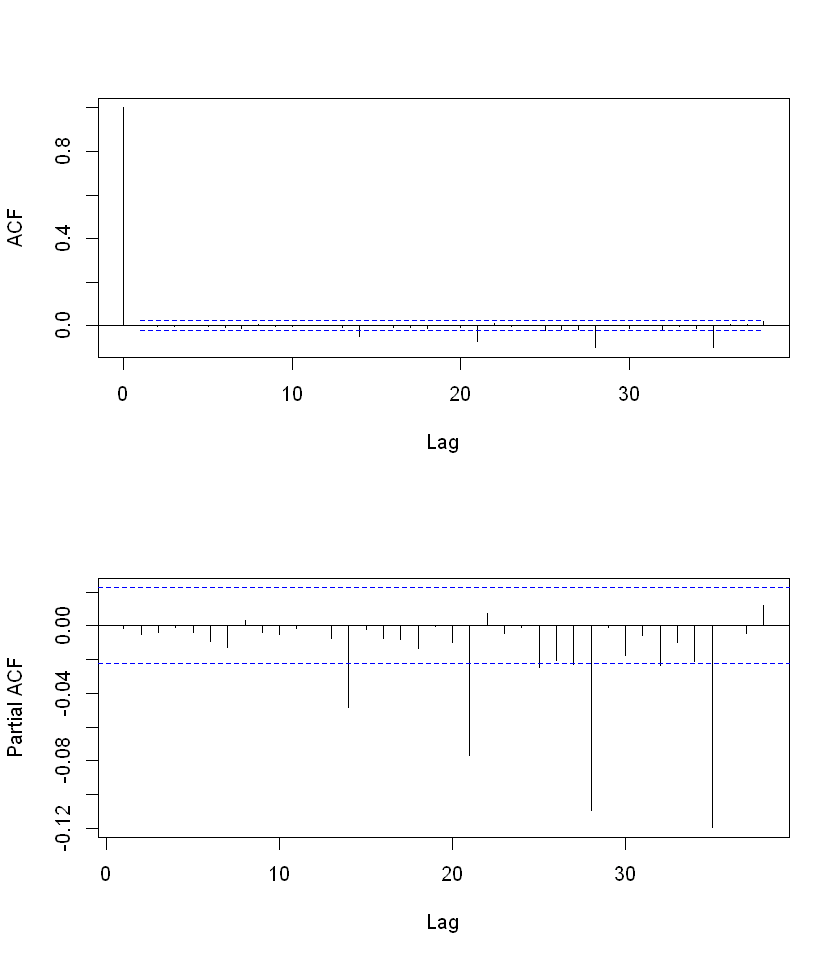

In [399]:
library(stats)
options(repr.plot.weight=16,repr.plot.height=8)
ordenmaximo=40
mod1=ar.ols(x = m.log.est7,aic = TRUE,order.max = ordenmaximo)
resid1<-mod1$resid[(ordenmaximo+1):length(mod1$resid)]
#resid1
par(mfrow=c(2,1))
acf(resid1,main="",ci.type="ma")
pacf(resid1,main="")


# Hago pruebas en los residuales para mirar su heterocedasticidad
# Validacion de los supuestos sobre los Errores

## Imprimir el histograma

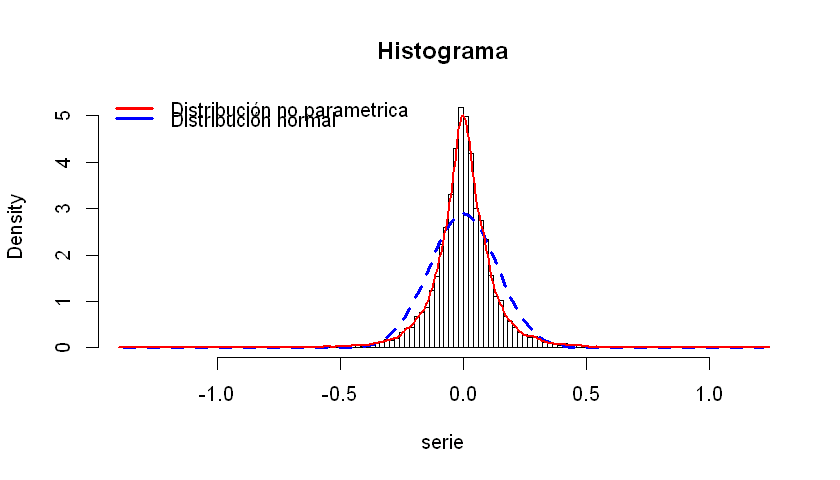

In [405]:
options(repr.plot.weight=8,repr.plot.height=4)
imprimir_histograma(resid1) # imprime el histograma

## Pruba Ljung-Box

Se rechaza $H_0$ los residuos no son riudo Blanco

In [401]:
Box.test(resid1,lag=40,type="Ljung-Box")


	Box-Ljung test

data:  resid1
X-squared = 246.66, df = 40, p-value < 2.2e-16


# Pruba Durbin Watson a los residuos

In [402]:
library(car)
durbinWatsonTest(resid1)

[1] 2.002338

## QQ Plot


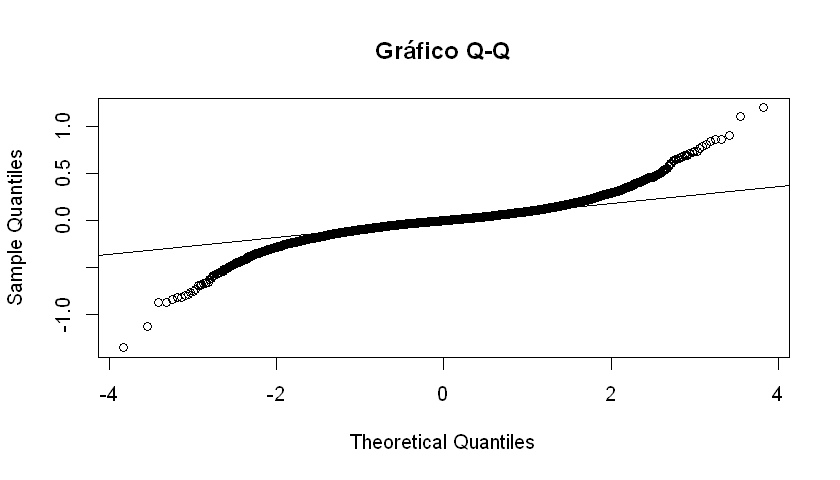

In [404]:
options(repr.plot.weight=8,repr.plot.height=4)
grafico_qqplot(resid1)

Es claro que existe una estructura en los residuos del  ajuste,es decir que el supuesto de incorrelacion no es valido. Por lo tanto se procede a hacer pruebas de heterocedasticidad

In [406]:
mod1


Call:
ar.ols(x = m.log.est7, aic = TRUE, order.max = ordenmaximo)

Coefficients:
      1        2        3        4        5        6        7        8  
-0.1633  -0.0242  -0.0530  -0.0356  -0.0326  -0.0344  -0.7906  -0.1253  
      9       10       11       12       13       14       15       16  
-0.0480  -0.0324  -0.0495  -0.0376  -0.0312  -0.6466  -0.0969  -0.0497  
     17       18       19       20       21       22       23       24  
-0.0156  -0.0418  -0.0279  -0.0214  -0.4753  -0.0758  -0.0459  -0.0210  
     25       26       27       28       29       30       31       32  
-0.0476  -0.0089  -0.0180  -0.2928  -0.0476  -0.0213  -0.0058  -0.0419  
     33       34       35       36       37       38       39       40  
-0.0067  -0.0019  -0.1380  -0.0352  -0.0190  -0.0006  -0.0081  -0.0145  

Intercept: -0.0007303 (0.001584) 

Order selected 40  sigma^2 estimated as  0.01901

# Miremos los Residuales$^2$


In [409]:
resid_cuad<-resid1^2

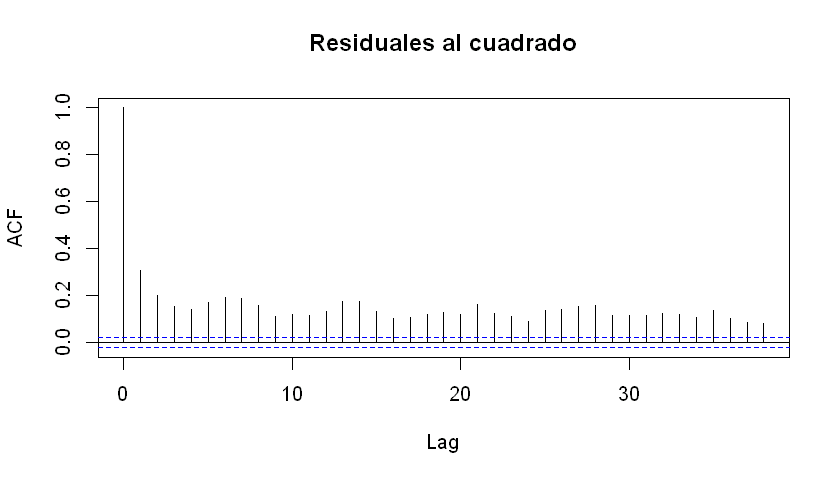

In [410]:
acf(resid_cuad,main="Residuales al cuadrado")
par(mfrow=c(1,2))

# Pruebas de Heterocedasticidad

## Breusch-Pagan

In [407]:
library(lmtest)
bptest(resid1,studentize = FALSE)

ERROR: Error in formula$x: $ operator is invalid for atomic vectors


## Goldfield-Quandt

In [408]:
gqtest(resid1)

ERROR: Error in formula$x: $ operator is invalid for atomic vectors


# Modelo para los errores